In [1]:
import pennylane as qml
from pennylane import numpy as np
from functools import partial
import matplotlib.pyplot as plt

In [2]:
from datasets import *

train_X, test_X, train_y, test_y = get_xor_data(200)
len(train_X)

180

In [3]:
s_params_size=1

In [439]:
dev = qml.device("default.qubit", wires=1)

def encode_and_rotate(x_i,s_params,w_params): 
    # input vector x   
    rx_angle = -2*s_params[0]*x_i[0]    
    ry_angle = -2*s_params[0]*x_i[1]
    qml.RY(ry_angle,0)
    qml.RX(rx_angle,0)
    qml.RX(-2*w_params[0],0)    
    qml.RY(-2*w_params[1],0)
    qml.RZ(-2*w_params[2],0)    

In [440]:
@qml.qnode(dev)
def vqc_model(x_i, params):
    s_params,w_params = params[:s_params_size], params[s_params_size:]
    encode_and_rotate(x_i, s_params,w_params)
    return qml.expval(qml.PauliZ(0))  

In [441]:
def loss(data, labels, model, params):    
    loss_sum = []
    for idx in range(len(data)):
        data_point = data[idx]
        true_label = labels[idx]
        model_output = model(data_point, params)
        if (model_output<0 and true_label>0) or (model_output>0 and true_label<0):
#             print(model_output, true_label)
            loss_sum.append((model_output - true_label) ** 2)

    return sum(loss_sum)/len(data)
#     return sum(loss_sum)/len(loss_sum)
#     return loss_sum / len(data)


def make_prediction(model, data_point, params):
    measurement_result = model(data_point, params)
    if measurement_result < 0:
        return -1
    return 1

def compute_accuracy(data, labels, model, params):
    n_samples = len(data)
#     for x in range(n_samples):
#         print(make_prediction(model, data[x], params),labels[x])
    return np.sum(
        [make_prediction(model, data[x], params) == labels[x] for x in range(n_samples)
    ]) / n_samples

In [442]:
def get_initial_dataset(train_X,train_Y):
    size_to_return = int(0.04*len(train_X))
    curr_train_X, curr_train_y = [],[]
    idx = np.random.choice(len(train_X), size_to_return)
    for i in idx:
        curr_train_X.append(train_X[i])        
        curr_train_y.append(train_Y[i])
    curr_train_X = np.array(curr_train_X, requires_grad=False)
    curr_train_y = np.array(curr_train_y, requires_grad=False)
    return curr_train_X,curr_train_y

In [470]:
# start_point_itrs = 50

# for _ in range(start_point_itrs):
# print("__________________________________________________")
s_params_size, w_params_size = 1,3
params = np.random.normal(size=(s_params_size+w_params_size))#*100
# params = np.array([-0.0100819 ,  0.78670324, -0.29197941,  0.26170104])
print(params)
# opt = qml.AdamOptimizer(stepsize=0.00087)
opt = qml.GradientDescentOptimizer(stepsize=0.009)
num_its = 100
loss_over_time = []
# curr_train_X, curr_train_y = get_initial_dataset(train_X,train_y)
for itr in range(num_its):
    (_, _, _, params), _loss = opt.step_and_cost(loss, train_X, train_y, vqc_model, params)
    loss_over_time.append(_loss)
    print("Iteration:",itr, "Loss:",_loss)



[-0.3391708   0.48349271 -0.33237846  0.79424996]
Iteration: 0 Loss: 1.3426234693539707
Iteration: 1 Loss: 1.3364768158243527
Iteration: 2 Loss: 1.3298216330208477
Iteration: 3 Loss: 1.3339068655626696
Iteration: 4 Loss: 1.3269367308745712
Iteration: 5 Loss: 1.3250234394975227
Iteration: 6 Loss: 1.3285573617417248
Iteration: 7 Loss: 1.3205741559221058
Iteration: 8 Loss: 1.3118410695721485
Iteration: 9 Loss: 1.302274494671817
Iteration: 10 Loss: 1.2917840777225376
Iteration: 11 Loss: 1.2747332000444809
Iteration: 12 Loss: 1.2622465966018204
Iteration: 13 Loss: 1.24314418078889
Iteration: 14 Loss: 1.2283814633505818
Iteration: 15 Loss: 1.217899622079082
Iteration: 16 Loss: 1.1951946899099795
Iteration: 17 Loss: 1.1769669746116982
Iteration: 18 Loss: 1.1572338077485012
Iteration: 19 Loss: 1.1359502936554697
Iteration: 20 Loss: 1.113100684727024
Iteration: 21 Loss: 1.0831886031048814
Iteration: 22 Loss: 1.057459407658886
Iteration: 23 Loss: 1.0193386379811464
Iteration: 24 Loss: 0.99704208

In [471]:
training_accuracy = compute_accuracy(train_X, train_y, vqc_model, params)
testing_accuracy = compute_accuracy(test_X, test_y, vqc_model, params)

print(f"Training accuracy = {training_accuracy}")
print(f"Testing accuracy = {testing_accuracy}")

Training accuracy = 0.4222222222222222
Testing accuracy = 0.55


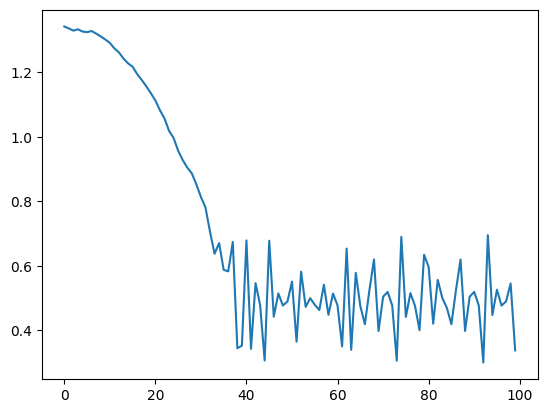

In [472]:
plt.plot(loss_over_time)
plt.show()

In [473]:
params

tensor([-0.00773873,  0.78467703, -0.37318467,  0.79424996], requires_grad=True)

In [ ]:
# https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html
# when benchmarking the WINE and IRIS for ternary classification

In [3]:
from datasets import *
# get_moon_dataset(100)
iris_dataset()

(tensor([[6.3, 3.3, 4.7, 1.6],
         [6.5, 3. , 5.8, 2.2],
         [5.6, 2.5, 3.9, 1.1],
         [5.7, 2.8, 4.5, 1.3],
         [6.4, 2.8, 5.6, 2.2],
         [4.7, 3.2, 1.6, 0.2],
         [6.1, 3. , 4.9, 1.8],
         [5. , 3.4, 1.6, 0.4],
         [6.4, 2.8, 5.6, 2.1],
         [7.9, 3.8, 6.4, 2. ],
         [6.7, 3. , 5.2, 2.3],
         [6.7, 2.5, 5.8, 1.8],
         [6.8, 3.2, 5.9, 2.3],
         [4.8, 3. , 1.4, 0.3],
         [4.8, 3.1, 1.6, 0.2],
         [4.6, 3.6, 1. , 0.2],
         [5.7, 4.4, 1.5, 0.4],
         [6.7, 3.1, 4.4, 1.4],
         [4.8, 3.4, 1.6, 0.2],
         [4.4, 3.2, 1.3, 0.2],
         [6.3, 2.5, 5. , 1.9],
         [6.4, 3.2, 4.5, 1.5],
         [5.2, 3.5, 1.5, 0.2],
         [5. , 3.6, 1.4, 0.2],
         [5.2, 4.1, 1.5, 0.1],
         [5.8, 2.7, 5.1, 1.9],
         [6. , 3.4, 4.5, 1.6],
         [6.7, 3.1, 4.7, 1.5],
         [5.4, 3.9, 1.3, 0.4],
         [5.4, 3.7, 1.5, 0.2],
         [5.5, 2.4, 3.7, 1. ],
         [6.3, 2.8, 5.1, 1.5],
        